In [1]:
import os
import numpy as np
import json
import torch
import torch.nn as nn
from torch.nn import Parameter
from scipy.misc import imread, imresize
from torch.utils.data import Dataset
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
%matplotlib inline
import warnings
import skimage.transform
warnings.filterwarnings('ignore')

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
#         resnet = torchvision.models.resnet101(pretrained=True)
        vgg = torchvision.models.vgg16(pretrained=True)
        all_modules = list(vgg.children())
        modules = all_modules[:-2]
        self.vgg = nn.Sequential(*modules)
        self.avgpool = nn.AvgPool2d(8)
        self.fine_tune()
    
    def forward(self, images):
        """
        Forward function
        input: - images : with shape (batch_size, 3, 224, 224) channel first
        """
        # get the images features
        encoded_image = self.vgg(images) # (batch_size, 512, 8, 8)
        
        batch_size = encoded_image.shape[0]
        features = encoded_image.shape[1]
        num_pixels = encoded_image.shape[2] * encoded_image.shape[3]
        # get the global feature by using average pooling and rsshape it to batch_size, 512 (14)
        global_features = self.avgpool(encoded_image).view(batch_size, -1) # (batch_size, 512)
        # get the encoded image by resize the image feature
        enc_image = encoded_image.permute(0, 2, 3, 1) # (batch_size, 7, ,7, 512)
        enc_image = enc_image.view(batch_size, num_pixels, features) # (batch_size, num_pixels, 512)
        return enc_image, global_features
    
    def fine_tune(self, status=False):
        if not status:
            for param in self.vgg.parameters():
                param.requires_grad = False
        else:
            for module in list(self.vgg.children())[5:]: # last layer only, len total layer is 8
                for param in module.parameters():
                    param.requires_grad = True

In [4]:
class AdaptiveLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(AdaptiveLSTMCell, self).__init__()
        # create LSTM cell
        self.lstm_cell = nn.LSTMCell(input_size, hidden_size)
        # create input gate
        self.x_gate = nn.Linear(input_size, hidden_size)
        # crate hidden gate
        self.h_gate = nn.Linear(hidden_size, hidden_size)
        
    def forward(self, x, states):
        """
        Forward function for LSTM
        input: - x : word token combined with encoded_image
               - states : the old hidden cell and memory cell
        """
        h_old, m_old = states
        # do LSTM, and get new hidden and output
        ht, mt = self.lstm_cell(x, (h_old, m_old))
        # do sigmoid to the input and hidden to get visual sentinel St (9)
        gt = F.sigmoid(self.x_gate(x) + self.h_gate(h_old))
        # and then do tanh to get visual sentinel (10)
        st = gt * F.tanh(mt)
        return ht, mt, st

In [5]:
class AdaptiveAttention(nn.Module):
    def __init__(self, hidden_size, attention_dimension):
        super(AdaptiveAttention, self).__init__()
        self.sentinel_affine= nn.Linear(hidden_size, hidden_size)
        self.sentinel_attention = nn.Linear(hidden_size, attention_dimension)
        self.hidden_affine = nn.Linear(hidden_size, hidden_size)
        self.hidden_attention = nn.Linear(hidden_size, attention_dimension)
        self.visual_attention = nn.Linear(hidden_size, attention_dimension)
        self.alphas = nn.Linear(attention_dimension, 1)
        self.context_hidden = nn.Linear(hidden_size, hidden_size)
   
    def forward(self, spatial_image, decoder_output, st):
        """
        Forward function for Adaptive Attention
        input: - spatial_image : the spatial image with shape (batch_size, num_pixels, hidden_size)
               - decoder_output : the decoder hidden state with shape (batch_size, hidden_size)
               - st : Visual sentinel returned by sentinel class with shape (batch_size, hidden_size)
        """
        # extract num_pixels
        num_pixels = spatial_image.shape[1]
        # get the visual attention using spatial_image as input
        visual_attn = self.visual_attention(spatial_image) # (batch_size, num_pixels, att_dim)
        # get sentinel affine using st as input with ReLU activation
        sentinel_affine = F.relu(self.sentinel_affine(st)) # (batch_size, hidden_size)
        # get sentinel attention using sentinel_affine as input
        sentinel_attn = self.sentinel_attention(sentinel_affine) # (batch_size, att_dim)
        
        hidden_affine = F.tanh(self.hidden_affine(decoder_output)) # (batch_sizem hidden_size)
        hidden_attn = self.hidden_attention(hidden_affine) # (batch_size, attention_dimension)
        
        hidden_resized = hidden_attn.unsqueeze(1).expand(hidden_attn.size(0), num_pixels + 1, hidden_attn.size(1))
        
        concat_features = torch.cat([spatial_image, sentinel_affine.unsqueeze(1)], dim=1) # (batch_size, num_pixels+1, hidden_size)
        attended_features = torch.cat([visual_attn, sentinel_attn.unsqueeze(1)], dim=1) # (batch_size, num_pixels, attn_dim)
        
        # do tanh to attended and hidden (6)
        attention = F.tanh(attended_features + hidden_resized) # (batch_size, num_pixles+1, attn_dim)
        # do a forward linear layer
        alpha = self.alphas(attention).squeeze(2) # (batch_size, num_pixels+1)
        # and do softmax
        att_weights = F.softmax(alpha, dim=1) # (batch_size, num_pixels+1)
        
        context = (concat_features * att_weights.unsqueeze(2)).sum(dim=1) # (batch_size, hidden_size)
        # get the new beta value by getting the last value of att_weights
        beta_value = att_weights[:, -1].unsqueeze(1) #(batch_size, 1)
        
        out_l = F.tanh(self.context_hidden(context + hidden_affine))
        
        return out_l, att_weights, beta_value
        
        
        

In [6]:
class Decoder(nn.Module):
    def __init__(self, hidden_size, vocab_size, attention_dimension, embed_size, encoded_dimension):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(hidden_size, vocab_size)
        self.encoded_to_hidden = nn.Linear(encoded_dimension, hidden_size)
        self.global_features = nn.Linear(encoded_dimension, embed_size)
        # input of the LSTMCell should be of shape (batch_size, input_size)
        # because the input and global features are concenated, then input_features should be embed_size*2
        self.LSTM = AdaptiveLSTMCell(embed_size*2, hidden_size)
        self.adaptive_attention = AdaptiveAttention(hidden_size, attention_dimension)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.vocab_size = vocab_size
        self.dropout = nn.Dropout(0.5)
        self.init_weights()
        
    def init_weights(self):
        self.fc.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        self.embedding.weight.data.uniform_(-0.1, 0.1)
    
    def init_hidden_state(self, encoded_image):
        h = torch.zeros(encoded_image.shape[0], 512).to(device)
        c = torch.zeros(encoded_image.shape[0], 512).to(device)
        return h, c

    def forward(self, encoded_image, global_features, encoded_captions, caption_lengths):
        """
        Forward function for decoder
        input: - encoded_image : the encoded images from encoder with shape (batch_size, num_pixels, 2048)
               - global_features : the global features from encoder with shape (batch_size, 2048)
               - encoded_captions : encoded captions with shape (batch_size, max_caption_length)
               - caption_lengths : encoded caption length with dimension (batch_size, 1)
        """
        # extract the batch size and num_pixels
        batch_size = encoded_image.shape[0]
        num_pixels = encoded_image.shape[1]
        # get the spatial image
        spatial_image = F.relu(self.encoded_to_hidden(encoded_image)) # (batch_size, num_pixels, hidden_size)
        global_image = F.relu(self.global_features(global_features)) # (batch_size, embed_size)
        # sort input data by decreasing length
        # caption_length will contains the sorted length, and sort_idx will contains the sorted elements indices
        caption_lengths, sort_idx = caption_lengths.squeeze(1).sort(dim=0, descending=True)
        # sort spatial_image, global_image, encoded_captions and encoded_image batches by caption length
        spatial_image = spatial_image[sort_idx]
        global_image = global_image[sort_idx]
        encoded_captions = encoded_captions[sort_idx]
        encoded_image = encoded_image[sort_idx]
        
        # Embedding, each batch contains a caption. All batch have the same number of rows (words), since we previously
        # padded the ones shorter than max_caption_lengths, as well as the same number of columns (embed_dimension)
        embeddings = self.embedding(encoded_captions) # (batch_size, max_caption_length, embed_dimesion)
        
        # initialize LSTM
        h, c = self.init_hidden_state(encoded_image) # (batch_size, hidden_size)
        
        # we won't decode at the <end> position, since we've finished generating as soon as we generate <end>
        decode_lengths =(caption_lengths - 1).tolist()
        
        # create tensors to store word prediction score, alphas and betas
        predictions = torch.zeros(batch_size, max(decode_lengths), self.vocab_size).to(device)
        alphas = torch.zeros(batch_size, max(decode_lengths), num_pixels+1).to(device)
        betas = torch.zeros(batch_size, max(decode_lengths), 1).to(device)
        
        # concenate the embeddings and global image feature for LSTM input
        global_image = global_image.unsqueeze(1).expand_as(embeddings)
        inputs = torch.cat((embeddings, global_image), dim=2) # (batch_size, max_caption_length, embed_dimension * 2)
        
        # start decoding
        for timestep in range(max(decode_lengths)):
            # create a packet sequence to process the only effective batch size N_t at that timestep
            batch_size_t = sum([l > timestep for l in decode_lengths])
            current_input = inputs[:batch_size_t, timestep, :] # (batch_size_t, embed_dimension * 2)
            # do LSTM
            h, c, st = self.LSTM(current_input, (h[:batch_size_t], c[:batch_size_t])) # (batch_size, hidden_size)
            # run the adaptive attention
            out_l, alpha_t, beta_t = self.adaptive_attention(spatial_image[:batch_size_t], h, st)
            # compute the probability over the vocabulary with fullt connected layer
            pred = self.fc(self.dropout(out_l))
            # store the prediction, alphas and betas value
            predictions[:batch_size_t, timestep, :] = pred
            alphas[:batch_size_t, timestep, :] = alpha_t
            betas[:batch_size_t, timestep, :] = beta_t
        return predictions, alphas, betas, encoded_captions, decode_lengths, sort_idx

In [7]:
with open('caption data/WORDMAP.json', 'r') as j:
    word_map = json.load(j)

rev_word_map = {v: k for k, v in word_map.items()}  # idx2word

In [8]:
def predict_output(image, rev_word_map):
    """
    predict output with beam size of 1 (predict the word and feet it to the next LSTM)
    print out the generated sentence
    """
    max_len = 20
    sampled = []
    img = imread(image)
    img = imresize(img, (256, 256)) # (224, 224, 3)
    img = img.transpose(2, 0, 1) # channel first (3, 224, 224)
    img = img / 255. # normalize the input to 0 - 1
    img = torch.FloatTensor(img).to(device) # convert to tensor
    # normalize the input image
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
    transform = transforms.Compose([normalize])
    image = transform(img.to('cpu')).to(device)  # (3, 224, 224)
    
    # add single batch
    image = image.unsqueeze(0) # (1, 3, 224, 224)
    encoded_image, global_features = encoder(image)
    num_pixels = encoded_image.shape[1]
    spatial_image = F.relu(decoder.encoded_to_hidden(encoded_image)) # (batch_size, num_pixels, hidden_size)
    global_image = F.relu(decoder.global_features(global_features)) # (batch_size, embed_size)
    alphas = torch.zeros(max_len, num_pixels+1)
    betas = torch.zeros(max_len, 1)
    # create prediction with initial <start> token
    predictions = torch.LongTensor([[word_map['<start>']]]).to(device) # (1, 1)
    h, c = decoder.init_hidden_state(encoded_image)
    
    for timestep in range(max_len):
        embeddings = decoder.embedding(predictions).squeeze(1) # (1, 1, embed_dim) --> (1, embed_dim)
        inputs = torch.cat((embeddings, global_image), dim=1) # (1, embed_dim*2)
        h, c, st = decoder.LSTM(inputs, (h, c))
        out, alpha, beta = decoder.adaptive_attention(spatial_image, h, st)
        pt = decoder.fc(out)
        _, pred = pt.max(1)
        sampled.append(pred.item())
        alphas[timestep] = alpha
        betas[timestep] = beta.item()
    
    generated_words = [rev_word_map[sampled[i]] for i in range(len(sampled))]
    filtered_words = ' '.join([word for word in generated_words if word != '<end>'])
    print(filtered_words)
    

In [9]:
cudnn.benchmark = True
checkpoint = 'model_vgg.tar'
checkpoint = torch.load(checkpoint)
decoder = checkpoint['decoder']
decoder = decoder.to(device)
#decoder.eval()
encoder = checkpoint['encoder']
encoder = encoder.to(device)
#encoder.eval()

In [13]:
# Implementation with Beam Search
def caption_image_beam_search(encoder, decoder, image_path, word_map, beam_size=3):
    
    k = beam_size
    vocab_size = len(word_map)
    infinite_pred = False

    # Read image and process
    img = imread(image_path)
    if len(img.shape) == 2:
        img = img[:, :, np.newaxis]
        img = np.concatenate([img, img, img], axis=2)
    img = imresize(img, (224, 224))
    img = img.transpose(2, 0, 1)
    img = img / 255.
    img = torch.FloatTensor(img).to(device)
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
    transform = transforms.Compose([normalize])
    image = transform(img.to('cpu')).to(device)  # (3, 224, 224)
    # Encode
    image = image.unsqueeze(0)  # (1, 3, 224, 224)
    enc_image, global_features = encoder(image) #enc_image of shape (batch_size,num_pixels,features)
    print(enc_image.size())
    # Flatten encoding
    num_pixels = enc_image.size(1)
    encoder_dim = enc_image.size(2)
  
    # We'll treat the problem as having a batch size of k
    enc_image = enc_image.expand(k, num_pixels, encoder_dim)
    # Tensor to store top k previous words at each step; now they're just <start>
    k_prev_words = torch.LongTensor([[word_map['<start>']]] * k).to(device)  # (k, 1)
    # Tensor to store top k sequences; now they're just <start>
    seqs = k_prev_words  # (k, 1)
    # Tensor to store top k sequences' scores; now they're just 0
    top_k_scores = torch.zeros(k, 1).to(device)  # (k, 1)
    # Tensor to store top k sequences' alphas; now they're just 1s
    seqs_alpha = torch.ones(k, 1, 7, 7).to(device)  # (k, 1, enc_image_size, enc_image_size)
    #Tensor to store the top k sequences betas
    seqs_betas = torch.ones(k,1,1).to(device) 
    # Lists to store completed sequences, their alphas, betas and scores
    complete_seqs = list()
    complete_seqs_alpha = list()
    complete_seqs_scores = list()
    complete_seqs_betas = list()       
    # Start decoding
    step = 1
    h, c = decoder.init_hidden_state(enc_image)
    # s is a number less than or equal to k, because sequences are removed from this process once they hit <end>
    spatial_image = F.relu(decoder.encoded_to_hidden(enc_image))  # (k,num_pixels,hidden_size)
    global_image = F.relu(decoder.global_features(global_features))      # (1,embed_dim)
    
    while True:
        embeddings = decoder.embedding(k_prev_words).squeeze(1)  # (k,embed_dim)
        inputs = torch.cat((embeddings, global_image.expand_as(embeddings)), dim = 1)    
        h, c, st = decoder.LSTM(inputs , (h, c))  # (batch_size_t, hidden_size)
        # Run the adaptive attention model
        out_l, alpha, beta_t = decoder.adaptive_attention(spatial_image, h, st)
        alpha = alpha[:,:-1]
        alpha = alpha.view(-1, 7, 7)  # (s, enc_image_size, enc_image_size)
        # Compute the probability over the vocabulary
        scores = decoder.fc(out_l)      # (batch_size, vocab_size)
        scores = F.log_softmax(scores, dim=1)   # (s, vocab_size)
        # (k,1) will be (k,vocab_size), then (k,vocab_size) + (s,vocab_size) --> (s, vocab_size)
        scores = top_k_scores.expand_as(scores) + scores  
        # For the first step, all k points will have the same scores (since same k previous words, h, c)
        if step == 1:
            #Remember: torch.topk returns the top k scores in the first argument, and their respective indices in the second argument
            top_k_scores, top_k_words = scores[0].topk(k, 0, True, True)  # (s)
        else:
            # Unroll and find top scores, and their unrolled indices
            top_k_scores, top_k_words = scores.view(-1).topk(k, 0, True, True)  # (s)

        # Convert unrolled indices to actual indices of scores
        prev_word_inds = top_k_words / vocab_size  # (s) 
        next_word_inds = top_k_words % vocab_size  # (s) 
        # Add new words to sequences, alphas
        seqs = torch.cat([seqs[prev_word_inds], next_word_inds.unsqueeze(1)], dim=1)  # (s, step+1)
        # (s, step+1, enc_image_size, enc_image_size)
        seqs_alpha = torch.cat([seqs_alpha[prev_word_inds], alpha[prev_word_inds].unsqueeze(1)],dim=1)  
        seqs_betas = torch.cat([seqs_betas[prev_word_inds], beta_t[prev_word_inds].unsqueeze(1)], dim=1)  

        # Which sequences are incomplete (didn't reach <end>)?
        incomplete_inds = [ind for ind, next_word in enumerate(next_word_inds) if next_word != word_map['<end>']]
        complete_inds = list(set(range(len(next_word_inds))) - set(incomplete_inds))

        # Set aside complete sequences
        if len(complete_inds) > 0:
            complete_seqs.extend(seqs[complete_inds].tolist())
            complete_seqs_alpha.extend(seqs_alpha[complete_inds].tolist())
            complete_seqs_scores.extend(top_k_scores[complete_inds])
            complete_seqs_betas.extend(seqs_betas[complete_inds])   
        k -= len(complete_inds)  # reduce beam length accordingly

        # Proceed with incomplete sequences
        if k == 0:
            break
            
        seqs = seqs[incomplete_inds]              
        seqs_alpha = seqs_alpha[incomplete_inds]   
        seqs_betas = seqs_betas[incomplete_inds]    
        h = h[prev_word_inds[incomplete_inds]]
        c = c[prev_word_inds[incomplete_inds]]
        spatial_image = spatial_image[prev_word_inds[incomplete_inds]]
        top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
        k_prev_words = next_word_inds[incomplete_inds].unsqueeze(1)

        # Break if things have been going on too long
        if step > 50:
            infinite_pred = True
            break
            
        step += 1
        
    if infinite_pred is not True:
        i = complete_seqs_scores.index(max(complete_seqs_scores))
        seq = complete_seqs[i]
    else:
        i = 0
        seq = seqs[i][:20]
        seq = [seq[j].item() for j in range(len(seq))]
        
    alphas = complete_seqs_alpha[i]
    betas = complete_seqs_betas[i] 

    return seq, alphas, betas   

In [10]:
def visualize_att(image_path, seq, alphas, betas, rev_word_map, smooth=True):
    """
    Visualizes caption with weights at every word.
    Adapted from paper authors' repo: https://github.com/kelvinxu/arctic-captions/blob/master/alpha_visualization.ipynb
    :param image_path: path to image that has been captioned
    :param seq: caption
    :param alphas: weights
    :param rev_word_map: reverse word mapping, i.e. ix2word
    :param smooth: smooth weights?
    """
    image = Image.open(image_path)
    orig_image = image
    image = image.resize([7 * 7, 7 * 7], Image.LANCZOS)
    words = [rev_word_map[ind] for ind in seq]
    print('Predicted caption: ', ' '.join(words[1:-1]))
    
    plt.imshow(orig_image)
    plt.show()

    for t in range(len(words)):
        if t > 50:
            break
        plt.subplot(1, len(words), t + 1)
        plt.text(0, 1, '%s' % (words[t]), color='black', backgroundcolor='white', fontsize=12)
        plt.text(10, 65, '%.2f' % (1-(betas[t].item())), color='green', backgroundcolor='white', fontsize=15)
        plt.imshow(image)
        current_alpha = alphas[t, :]
        if smooth:
            alpha = skimage.transform.pyramid_expand(current_alpha.numpy(), upscale=7, sigma=7)
        else:
            alpha = skimage.transform.resize(current_alpha.numpy(), [7 * 7, 7 * 7])
        if t == 0:
            plt.imshow(alpha, alpha=0)
        else:
            plt.imshow(alpha, alpha=0.5)
        plt.set_cmap('jet')
        plt.axis('off')
        
    plt.show()

In [16]:
def PlotAttention(image_path, seq, alphas, betas, rev_word_map):
    image = Image.open(image_path)
    image = image.resize([7 * 7, 7 * 7], Image.LANCZOS)
    words = [rev_word_map[ind] for ind in seq]
    betas = 1 - (betas.cpu().detach().numpy())
    x = np.arange(betas.shape[0])
    
    fig = plt.figure(figsize=(10,2))
    ax = plt.subplot(1, 1, 1)
    ax.plot(betas[1:-1], marker='o')
    ax.grid(axis='y')
    ax.set_ylim([0, 1])
    ax.set_xticklabels(words[:-1])
#     ax.set_ylabel('Visual Grounding Probability', horizontalalignment='bottom')
    
    xl, yl, xh, yh=np.array(ax.get_position()).ravel()
    size=0.5
    start = -0.075
    distance = 0.1151 #0.1128
    
    for i in range(len(words)-2):
        current_alpha = alphas[i+1, :]
        alpha = skimage.transform.pyramid_expand(current_alpha.numpy(), upscale=7, sigma=7)
        axx = fig.add_axes([start + i*distance, yh, size, size])
        axx.axison = False
        axx.imshow(image)
        axx.imshow(alpha, alpha=0.4)
        addition = -0.15
        if betas[i+1][0] < 0.2:
            addition = 0.12
        ax.text(x[i], betas[i+1][0]+addition, "{0:.3f}".format(betas[i+1][0]), horizontalalignment='center')

In [11]:
def PlotImageCaption(image_path, seq, rev_word_map):
    image = Image.open(image_path)
    image = image.resize([224, 224], Image.LANCZOS)
    words = [rev_word_map[ind] for ind in seq]
    plt.axis('off')
    plt.imshow(image)
#     plt.text(len(words)+10, 232, ' '.join(words[1:-1]), color='black', backgroundcolor='white', fontsize=15)
#     plt.text(len(words)+10, 232, ' '.join(words[1:-1]), color='black', backgroundcolor='white', fontsize=15)
    plt.show()
    print(' '.join(words[1:-1]))

torch.Size([1, 49, 512])


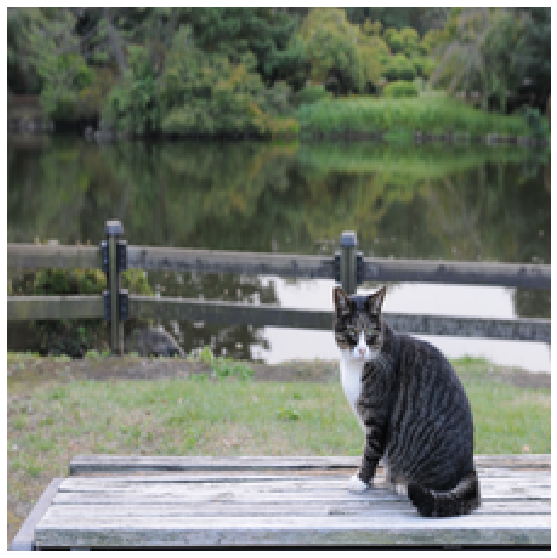

kucing duduk di atas bangku kayu


In [14]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
img_file = 'test_imgs/test10.jpg'
plt.rcParams['figure.figsize'] = (10, 10)  # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
# Encode, decode with attention and beam search k=3
seq, alphas, betas = caption_image_beam_search(encoder, decoder, img_file, word_map, beam_size=3)
alphas = torch.FloatTensor(alphas)
#visualize_att(img_file, seq, alphas, betas, rev_word_map, smooth=True)
# words = [rev_word_map[ind] for ind in seq]
# print('Predicted caption: ', ' '.join(words[1:-1]))
#image = Image.open(img_file)
# image = image.resize([100, 100], Image.LANCZOS)
# plt.imshow(image)
# plt.xticks([])
# plt.yticks([])
# plt.show()
# PlotAttention(img_file, seq, alphas, betas, rev_word_map)
PlotImageCaption(img_file, seq, rev_word_map)

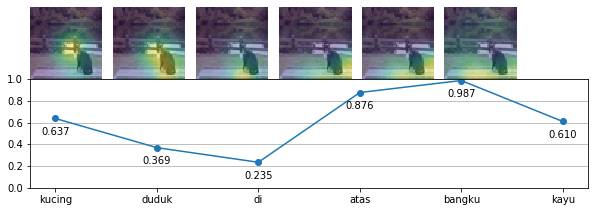

In [19]:
#visualize_att(img_file, seq, alphas, betas, rev_word_map, smooth=True)
# words = [rev_word_map[ind] for ind in seq]
# print('Predicted caption: ', ' '.join(words[1:-1]))
#image = Image.open(img_file)
# image = image.resize([100, 100], Image.LANCZOS)
# plt.imshow(image)
# plt.xticks([])
# plt.yticks([])
# plt.show()
PlotAttention(img_file, seq, alphas, betas, rev_word_map)

In [29]:
encoder.vgg

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d